# Team Raj Datathon 2025

### Imports & Config

In [19]:
from pathlib import Path
from typing import Dict, List, Tuple
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from sklearn.linear_model import LinearRegression

from darts import TimeSeries
from darts.models import NaiveSeasonal, ExponentialSmoothing, Theta, AutoARIMA
from darts.utils.utils import SeasonalityMode

# %matplotlib inline

# ---------------- CONFIG ----------------
DATA_PATH = Path("data/climate_data_filtered_imputed.csv")

# Station for detailed 2024 plots (None auto-picks one with 2024 data + history)
PLOT_STATION: str | None = None

# 2026 forecast settings
FORECAST_YEAR = 2026
# None => auto-pick best model from leaderboard; or set to one of MODEL_NAMES
PREDICTION_MODEL: str | None = None

# Limit number of 2026 station outputs (None = all)
PLOT_MAX_STATIONS: int | None = None

# Models to backtest
MODEL_NAMES = [
    "NaiveSeasonal",
    "ExponentialSmoothing",
    "Theta",
    "LinearRegression(lags)",
    "AutoARIMA",
]

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)


### Utilities

### Station Helpers

In [20]:
def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if not np.any(mask):
        return np.nan
    return float(np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2)))

def sse_and_n(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[float, int]:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if not np.any(mask):
        return np.nan, 0
    sse = float(np.sum((y_true[mask] - y_pred[mask]) ** 2))
    n = int(np.sum(mask))
    return sse, n

def load_and_prepare(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    rename_map = {
        "Bureau of Meteorology station number": "station",
        "Year": "year",
        "Week": "week",
        "Maximum temperature (Degree C)": "tmax",
        "Minimum temperature (Degree C)": "tmin",
        "Rainfall amount (millimetres)": "rain",
    }
    df = df.rename(columns=rename_map)
    df["station"] = df["station"].astype(str)
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    df["week"] = pd.to_numeric(df["week"], errors="coerce").astype("Int64")
    for c in ["tmax", "tmin"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["station", "year", "week", "tmin", "tmax"]).copy()
    df = df.sort_values(["station", "year", "week"])
    return df

def station_series_temps(df: pd.DataFrame, station: str) -> tuple[TimeSeries, TimeSeries, pd.DataFrame]:
    s = df.loc[df["station"] == station].copy().sort_values(["year", "week"])
    s["t"] = np.arange(len(s))
    ts_min = TimeSeries.from_times_and_values(
        times=pd.RangeIndex(start=0, stop=len(s), step=1),
        values=s["tmin"].values.astype(float),
    )
    ts_max = TimeSeries.from_times_and_values(
        times=pd.RangeIndex(start=0, stop=len(s), step=1),
        values=s["tmax"].values.astype(float),
    )
    return ts_min, ts_max, s

def years_for_station(s: pd.DataFrame) -> List[int]:
    return s[["year"]].drop_duplicates().sort_values("year").astype(int)["year"].tolist()

def slices_for_year(s: pd.DataFrame, year: int) -> np.ndarray:
    return s.loc[s["year"] == year, "t"].values


### Models

In [21]:
def lr_lag_forecast(train_values: np.ndarray, horizon: int, p: int) -> np.ndarray:
    y = np.asarray(train_values, dtype=float)
    if len(y) == 0:
        return np.full(horizon, np.nan)
    if len(y) <= p:
        return np.full(horizon, float(np.nanmean(y)))

    X, Y = [], []
    for i in range(p, len(y)):
        X.append(y[i - p:i][::-1])  # y[t-1], y[t-2], ...
        Y.append(y[i])
    X = np.array(X); Y = np.array(Y)
    if len(Y) == 0:
        return np.full(horizon, float(np.nanmean(y)))
    model = LinearRegression().fit(X, Y)

    history = y.copy().tolist()
    preds = []
    for _ in range(horizon):
        last_p = np.array(history[-p:][::-1]) if len(history) >= p else np.array([history[-1]] * p)
        nxt = float(model.predict(last_p.reshape(1, -1)))
        preds.append(nxt)
        history.append(nxt)
    return np.array(preds)

def _safe_ns(ts_train: TimeSeries, season: int) -> NaiveSeasonal:
    K = max(1, min(season, len(ts_train)))
    return NaiveSeasonal(K=K)

def model_predict(name: str, ts_train: TimeSeries, horizon: int, season: int) -> np.ndarray:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if len(ts_train) == 0:
            return np.full(horizon, np.nan)

        if name == "NaiveSeasonal":
            return _safe_ns(ts_train, season).fit(ts_train).predict(horizon).values().ravel()

        if name == "ExponentialSmoothing":
            return ExponentialSmoothing().fit(ts_train).predict(horizon).values().ravel()

        if name == "Theta":
            min_points = 2 * max(1, season)
            model = _safe_ns(ts_train, season) if len(ts_train) < min_points else Theta(
                seasonality_period=season, season_mode=SeasonalityMode.ADDITIVE
            )
            return model.fit(ts_train).predict(horizon).values().ravel()

        if name == "LinearRegression(lags)":
            y = ts_train.values().ravel()
            return lr_lag_forecast(y, horizon=horizon, p=max(1, season))

        if name == "AutoARIMA":
            try:
                return AutoARIMA(seasonal=False, suppress_warnings=True).fit(ts_train).predict(horizon).values().ravel()
            except Exception:
                return _safe_ns(ts_train, season).fit(ts_train).predict(horizon).values().ravel()

        raise ValueError(f"Unknown model: {name}")


### Backtesting

In [22]:
def backtest_station_temps(
    df: pd.DataFrame, station: str, model_names: List[str]
) -> Tuple[pd.DataFrame,
           Dict[str, Dict[int, np.ndarray]], Dict[int, np.ndarray],
           Dict[str, Dict[int, np.ndarray]], Dict[int, np.ndarray]]:
    """
    Returns:
      metrics_df: [station, model, year, rmse, sse, n]  (pooled tmin+tmax)
      preds_min[model][year], actuals_min[year]
      preds_max[model][year], actuals_max[year]
    """
    ts_min, ts_max, s = station_series_temps(df, station)
    yrs = years_for_station(s)
    season = int(s["week"].nunique())

    metrics = []
    preds_min: Dict[str, Dict[int, np.ndarray]] = {m: {} for m in model_names}
    preds_max: Dict[str, Dict[int, np.ndarray]] = {m: {} for m in model_names}
    actuals_min: Dict[int, np.ndarray] = {}
    actuals_max: Dict[int, np.ndarray] = {}

    for i in range(1, len(yrs)):
        y_test = int(yrs[i])
        test_idx = slices_for_year(s, y_test)
        if len(test_idx) == 0:
            continue

        train_end_t = int(test_idx[0] - 1)
        ts_min_train = ts_min.drop_after(train_end_t)
        ts_max_train = ts_max.drop_after(train_end_t)
        H = len(test_idx)

        y_true_min = s.loc[s["year"] == y_test, "tmin"].astype(float).to_numpy()
        y_true_max = s.loc[s["year"] == y_test, "tmax"].astype(float).to_numpy()
        actuals_min[y_test] = y_true_min
        actuals_max[y_test] = y_true_max

        for name in model_names:
            try:
                y_pred_min = model_predict(name=name, ts_train=ts_min_train, horizon=H, season=season)
                y_pred_max = model_predict(name=name, ts_train=ts_max_train, horizon=H, season=season)

                sse_min, n_min = sse_and_n(y_true_min, y_pred_min)
                sse_max, n_max = sse_and_n(y_true_max, y_pred_max)
                sse_fold = (0.0 if np.isnan(sse_min) else sse_min) + (0.0 if np.isnan(sse_max) else sse_max)
                n_fold = n_min + n_max
                rmse_fold = np.sqrt(sse_fold / n_fold) if n_fold > 0 else np.nan
            except Exception:
                y_pred_min = np.full(H, np.nan)
                y_pred_max = np.full(H, np.nan)
                sse_fold, n_fold, rmse_fold = np.nan, 0, np.nan

            preds_min[name][y_test] = y_pred_min
            preds_max[name][y_test] = y_pred_max
            metrics.append({"station": station, "model": name, "year": y_test,
                            "rmse": rmse_fold, "sse": sse_fold, "n": n_fold})

    return pd.DataFrame(metrics), preds_min, actuals_min, preds_max, actuals_max

def run_all(df: pd.DataFrame):
    stations = sorted(df["station"].dropna().astype(str).unique().tolist())
    metrics_all = []
    all_preds_min: Dict[str, Dict[str, Dict[int, np.ndarray]]] = {}
    all_preds_max: Dict[str, Dict[str, Dict[int, np.ndarray]]] = {}
    all_actuals_min: Dict[str, Dict[int, np.ndarray]] = {}
    all_actuals_max: Dict[str, Dict[int, np.ndarray]] = {}

    for st in stations:
        m_df, pmin, amin, pmax, amax = backtest_station_temps(df, st, model_names=MODEL_NAMES)
        if not m_df.empty:
            metrics_all.append(m_df)
            all_preds_min[st] = pmin
            all_preds_max[st] = pmax
            all_actuals_min[st] = amin
            all_actuals_max[st] = amax

    metrics_all = pd.concat(metrics_all, ignore_index=True) if metrics_all else pd.DataFrame(
        columns=["station", "model", "year", "rmse", "sse", "n"]
    )
    return metrics_all, all_preds_min, all_actuals_min, all_preds_max, all_actuals_max

def leaderboard_from_metrics(metrics_all: pd.DataFrame) -> pd.DataFrame:
    m = metrics_all.copy().replace([np.inf, -np.inf], np.nan).dropna(subset=["sse", "n"])
    agg = (
        m.groupby("model", as_index=False)
         .agg(
             overall_sse=("sse", "sum"),
             total_points=("n", "sum"),
             mean_rmse=("rmse", "mean"),
             median_rmse=("rmse", "median"),
             sd_rmse=("rmse", "std"),
             folds=("rmse", "count"),
         )
    )
    agg["overall_rmse"] = np.sqrt(np.where(agg["total_points"] > 0,
                                           agg["overall_sse"] / agg["total_points"], np.nan))
    lb = agg.sort_values("overall_rmse").reset_index(drop=True)
    lb.insert(0, "rank", np.arange(1, len(lb) + 1))
    return lb[["rank", "model", "overall_rmse", "total_points", "folds", "mean_rmse", "median_rmse", "sd_rmse"]]


### Leaderboard

### Plotting

In [23]:
def pick_station_for_plot(df: pd.DataFrame) -> str | None:
    by_station = (
        df.groupby("station")
        .agg(years=("year", lambda x: sorted(set(int(y) for y in x))),
             n_2024=("year", lambda x: int(np.sum(x == 2024))))
        .reset_index()
    )
    candidates = by_station[(by_station["n_2024"] > 0) & (by_station["years"].apply(lambda ys: any(y < 2024 for y in ys)))]
    if candidates.empty:
        return None
    candidates["history_len"] = candidates["years"].apply(len)
    return str(candidates.sort_values(["history_len", "station"], ascending=[False, True]).iloc[0]["station"])

def plot_and_table_2024_per_model_temps(
    df: pd.DataFrame,
    station: str,
    preds_min: Dict[str, Dict[int, np.ndarray]],
    actuals_min: Dict[int, np.ndarray],
    preds_max: Dict[str, Dict[int, np.ndarray]],
    actuals_max: Dict[int, np.ndarray],
    model_order: List[str],
) -> None:
    _, _, s = station_series_temps(df, station)
    if 2024 not in actuals_min or 2024 not in actuals_max:
        print(f"[plot] Station {station} has no 2024 backtest.")
        return

    weeks_2024 = s.loc[s["year"] == 2024, "week"].astype(int).tolist()
    y_true_min = actuals_min[2024]
    y_true_max = actuals_max[2024]

    display(Markdown(f"## 2024 Predicted vs Actual — Station `{station}` (tmin & tmax)"))
    for name in model_order:
        ypm = preds_min.get(name, {}).get(2024, None)
        ypx = preds_max.get(name, {}).get(2024, None)
        if (ypm is None or not np.any(np.isfinite(ypm))) or (ypx is None or not np.any(np.isfinite(ypx))):
            continue

        # Fold RMSE pooled across tmin+tmax
        sse_m, n_m = sse_and_n(y_true_min, ypm)
        sse_x, n_x = sse_and_n(y_true_max, ypx)
        n_tot = n_m + n_x
        rmse_fold = np.sqrt((0 if np.isnan(sse_m) else sse_m) + (0 if np.isnan(sse_x) else sse_x)) / np.sqrt(n_tot) if n_tot > 0 else np.nan

        # Plot (tmin & tmax together)
        plt.figure(figsize=(10, 5))
        plt.plot(weeks_2024, y_true_min, marker="o", label="tmin actual")
        plt.plot(weeks_2024, ypm, marker="o", linestyle="--", label="tmin pred")
        plt.plot(weeks_2024, y_true_max, marker="o", label="tmax actual")
        plt.plot(weeks_2024, ypx, marker="o", linestyle="--", label="tmax pred")
        plt.title(f"{name} | RMSE (pooled) = {rmse_fold:.3f}")
        plt.xlabel("Week")
        plt.ylabel("Temperature (°C)")
        plt.grid(True, alpha=0.3)
        plt.legend(ncol=2)
        plt.tight_layout()
        plt.show()

        # Mini table
        tbl = pd.DataFrame({
            "week": weeks_2024,
            "tmin_actual": y_true_min,
            "tmin_pred": ypm,
            "tmax_actual": y_true_max,
            "tmax_pred": ypx,
        })
        display(tbl.round(3))


### 2026 Predictions

In [24]:
def _forecast_season_for_station_temps(
    df: pd.DataFrame, station: str, model_name: str, year: int
) -> Tuple[pd.DataFrame, List[int]]:
    ts_min, ts_max, s = station_series_temps(df, station)
    season = int(s["week"].nunique())
    H = season
    y_pred_min = model_predict(name=model_name, ts_train=ts_min, horizon=H, season=season)
    y_pred_max = model_predict(name=model_name, ts_train=ts_max, horizon=H, season=season)

    weeks = sorted(s["week"].dropna().astype(int).unique().tolist())
    if len(weeks) != H:
        weeks = list(range(1, H + 1))

    out = pd.DataFrame({
        "station": station, "year": year, "week": weeks,
        "pred_tmin": y_pred_min, "pred_tmax": y_pred_max
    })
    return out, weeks

def forecast_2026_all_stations_temps(
    df: pd.DataFrame, model_name: str, year: int
) -> pd.DataFrame:
    stations = sorted(df["station"].dropna().astype(str).unique().tolist())
    rows = []
    for st in stations:
        r, _ = _forecast_season_for_station_temps(df, st, model_name, year)
        rows.append(r)
    long_df = pd.concat(rows, ignore_index=True)
    return long_df

def plot_and_table_2026_per_station_temps(
    long_df: pd.DataFrame, model_name: str, year: int, max_stations: int | None = None
) -> None:
    stations = sorted(long_df["station"].unique().tolist())
    if isinstance(max_stations, int):
        stations = stations[:max_stations]

    display(Markdown(f"## {year} Predicted Weekly Temperatures — Model `{model_name}` (tmin & tmax)"))
    for st in stations:
        d = long_df[(long_df["station"] == st) & (long_df["year"] == year)].sort_values("week")
        if d.empty:
            continue
        weeks = d["week"].astype(int).tolist()

        plt.figure(figsize=(10, 5))
        plt.plot(weeks, d["pred_tmin"].values, marker="o", label="tmin pred")
        plt.plot(weeks, d["pred_tmax"].values, marker="o", label="tmax pred")
        plt.title(f"Station {st}")
        plt.xlabel("Week of Snow Season")
        plt.ylabel("Temperature (°C)")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

        display(d[["station", "year", "week", "pred_tmin", "pred_tmax"]].reset_index(drop=True).round(3))


### Run Backtest

Backtesting temperature models per station...

=== Leaderboard (Overall RMSE across both targets; lower is better) ===
 rank                  model  overall_rmse  total_points  folds  mean_rmse  median_rmse  sd_rmse
    1                  Theta      2.585930          2210     77   2.554554     2.527624 0.416255
    2              AutoARIMA      2.916809          2210     77   2.906870     2.864553 0.556686
    3          NaiveSeasonal      2.916809          2210     77   2.906870     2.864553 0.556686
    4   ExponentialSmoothing      3.544059          2000     70   3.459708     3.496015 0.836749
    5 LinearRegression(lags)      9.535969          2210     77   4.276786     2.500521 8.353356


,rank,model,overall_rmse,total_points,folds,mean_rmse,median_rmse,sd_rmse
0,1,Theta,2.586,2210,77,2.555,2.528,0.416
1,2,AutoARIMA,2.917,2210,77,2.907,2.865,0.557
2,3,NaiveSeasonal,2.917,2210,77,2.907,2.865,0.557
3,4,ExponentialSmoothing,3.544,2000,70,3.460,3.496,0.837
4,5,LinearRegression(lags),9.536,2210,77,4.277,2.501,8.353


## 2024 Predicted vs Actual — Station `71032` (tmin & tmax)

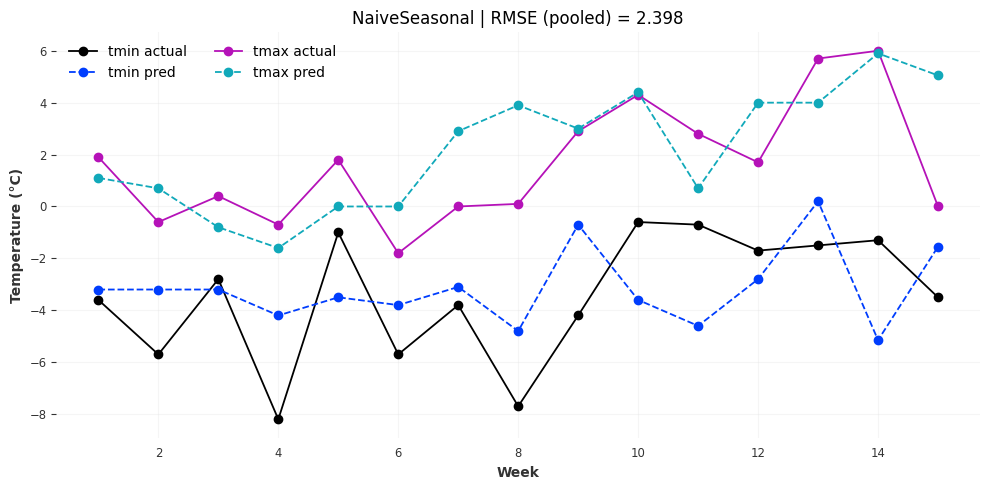

,week,tmin_actual,tmin_pred,tmax_actual,tmax_pred
0,1,-3.6,-3.20,1.9,1.10
1,2,-5.7,-3.20,-0.6,0.70
2,3,-2.8,-3.20,0.4,-0.80
3,4,-8.2,-4.20,-0.7,-1.60
4,5,-1.0,-3.50,1.8,0.00
5,6,-5.7,-3.80,-1.8,0.00
6,7,-3.8,-3.10,0.0,2.90
7,8,-7.7,-4.80,0.1,3.90
8,9,-4.2,-0.70,2.9,3.00
9,10,-0.6,-3.60,4.3,4.40


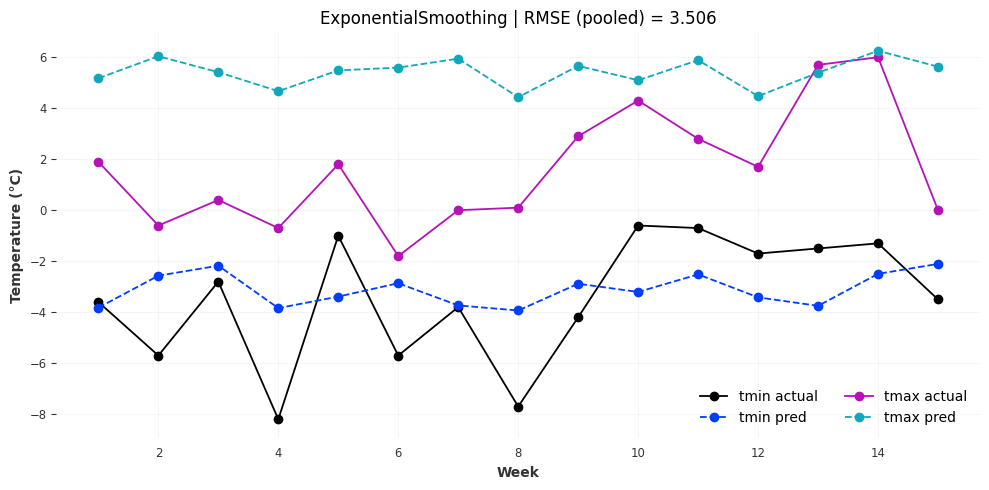

,week,tmin_actual,tmin_pred,tmax_actual,tmax_pred
0,1,-3.6,-3.822,1.9,5.176
1,2,-5.7,-2.568,-0.6,6.039
2,3,-2.8,-2.177,0.4,5.414
3,4,-8.2,-3.839,-0.7,4.668
4,5,-1.0,-3.388,1.8,5.485
5,6,-5.7,-2.864,-1.8,5.593
6,7,-3.8,-3.735,0.0,5.943
7,8,-7.7,-3.933,0.1,4.432
8,9,-4.2,-2.883,2.9,5.662
9,10,-0.6,-3.206,4.3,5.097


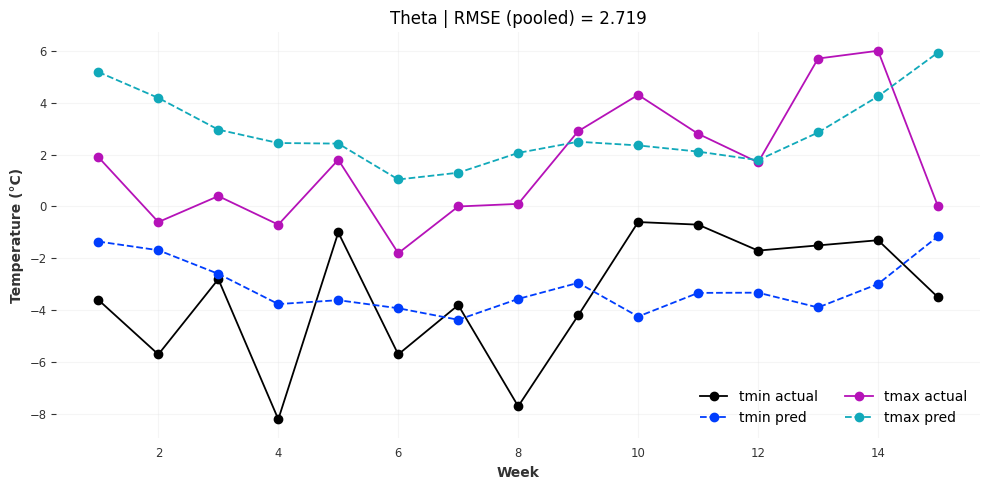

,week,tmin_actual,tmin_pred,tmax_actual,tmax_pred
0,1,-3.6,-1.351,1.9,5.181
1,2,-5.7,-1.685,-0.6,4.183
2,3,-2.8,-2.596,0.4,2.960
3,4,-8.2,-3.760,-0.7,2.445
4,5,-1.0,-3.611,1.8,2.423
5,6,-5.7,-3.920,-1.8,1.040
6,7,-3.8,-4.366,0.0,1.301
7,8,-7.7,-3.561,0.1,2.064
8,9,-4.2,-2.943,2.9,2.494
9,10,-0.6,-4.241,4.3,2.353


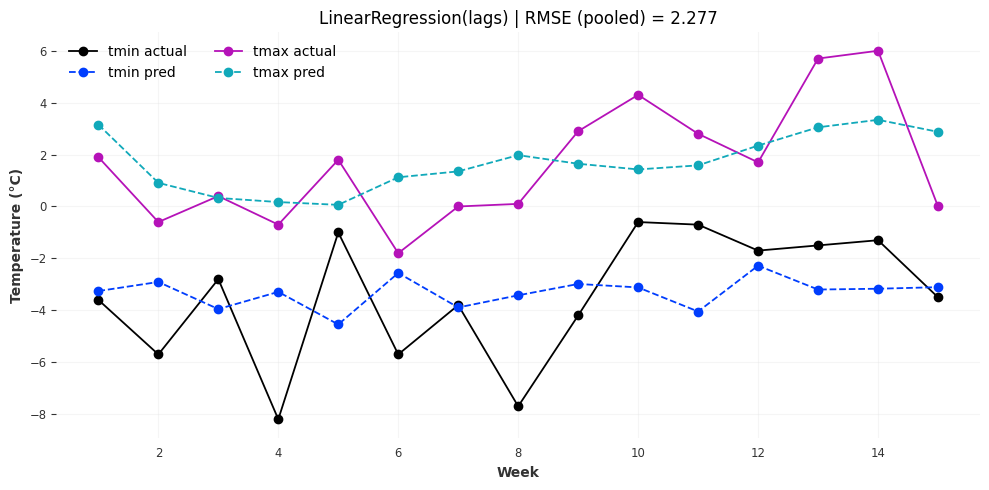

,week,tmin_actual,tmin_pred,tmax_actual,tmax_pred
0,1,-3.6,-3.258,1.9,3.153
1,2,-5.7,-2.908,-0.6,0.910
2,3,-2.8,-3.953,0.4,0.329
3,4,-8.2,-3.291,-0.7,0.170
4,5,-1.0,-4.545,1.8,0.063
5,6,-5.7,-2.562,-1.8,1.125
6,7,-3.8,-3.891,0.0,1.352
7,8,-7.7,-3.423,0.1,1.977
8,9,-4.2,-2.986,2.9,1.646
9,10,-0.6,-3.119,4.3,1.427


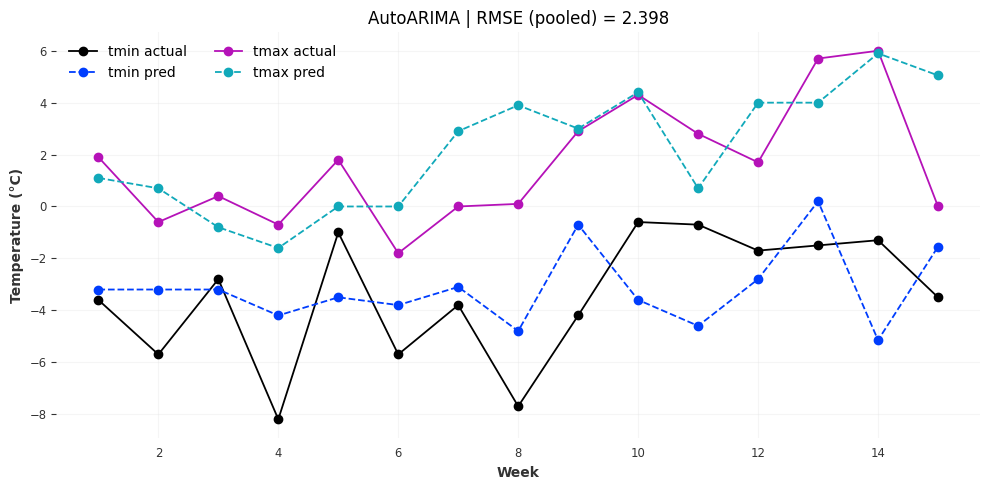

,week,tmin_actual,tmin_pred,tmax_actual,tmax_pred
0,1,-3.6,-3.20,1.9,1.10
1,2,-5.7,-3.20,-0.6,0.70
2,3,-2.8,-3.20,0.4,-0.80
3,4,-8.2,-4.20,-0.7,-1.60
4,5,-1.0,-3.50,1.8,0.00
5,6,-5.7,-3.80,-1.8,0.00
6,7,-3.8,-3.10,0.0,2.90
7,8,-7.7,-4.80,0.1,3.90
8,9,-4.2,-0.70,2.9,3.00
9,10,-0.6,-3.60,4.3,4.40



Forecasting 2026 weekly temperatures using model: Theta


## Overview table — 2026 predictions (stations × weeks × [tmin,tmax])

pred_tmax                                                          \
week           1      2      3      4      5      6      7      8      9    
station                                                                     
71032       0.787  0.936  0.830  0.389  1.267  2.916  4.522  3.141  2.155   
71075       3.382  3.776  3.597  4.399  6.642  7.569  7.285  4.729  4.065   
72161       3.796  4.753  5.508  6.733  7.718  8.556  8.697  4.954  5.382   
83024       0.784  1.980  1.658  2.902  4.392  5.094  5.035  3.123  2.691   
83084       0.431  1.169  1.371  2.378  4.236  4.930  4.724  2.526  1.698   
83085       0.013  0.846  0.579  1.659  3.673  4.837  3.056  2.341  1.437   
85291       1.958  3.359  3.151  4.180  6.504  6.796  6.584  4.355  3.802   

                                                  pred_tmin                \
week        10     11     12     13     14     15        1      2      3    
station                                                                     
71032    1.363  0.765  0.622 -0.449 -0.629  0.325    -3.810 -4.655 -3.504   
71075    3.514  2.869  2.054  1.837  2.862  3.345    -3.964 -2.526 -2.114   
72161    4.238  3.823  3.030  2.801  3.695  4.255    -0.530  0.241  0.418   
83024    1.340  1.365  0.366  0.462  0.780  1.391    -2.599 -1.533 -2.207   
83084    1.244  0.594 -0.061 -0.150  0.504  1.295    -2.962 -2.019 -2.131   
83085    0.274  0.266 -0.151 -0.386  0.150  0.882    -3.530 -2.274 -2.825   
85291    2.643  2.506  1.929  2.047  2.594  3.334    -1.390 -0.361 -0.948   

                                                                               \
week        4      5      6      7      8      9      10     11     12     13   
station                                                                         
71032   -3.501 -4.107 -3.257 -1.545 -2.055 -2.499 -3.125 -4.097 -4.355 -4.132   
71075   -2.999 -1.669 -0.387  0.010 -1.649 -2.856 -3.009 -2.938 -2.872 -3.447   
72161    0.142  1.504  1.686  2.498  1.020  0.361  0.201 -0.030 -0.311 -0.754   
83024   -1.991 -0.982 -0.798 -0.185 -0.694 -1.786 -1.947 -1.977 -2.003 -3.027   
83084   -2.749 -1.434 -0.686 -0.419 -1.046 -1.991 -2.283 -2.720 -2.483 -3.637   
83085   -2.913 -1.706 -0.940 -1.913 -1.931 -2.372 -2.813 -3.092 -2.764 -4.187   
85291   -0.743 -0.294  0.254 -0.080  0.411 -0.395 -0.702 -0.991 -0.682 -1.577   

                       
week        14     15  
station                
71032   -5.044 -4.204  
71075   -3.019 -2.385  
72161   -0.066 -0.041  
83024   -2.012 -1.690  
83084   -2.666 -2.163  
83085   -3.393 -2.801  
85291   -1.045 -0.722

## 2026 Predicted Weekly Temperatures — Model `Theta` (tmin & tmax)

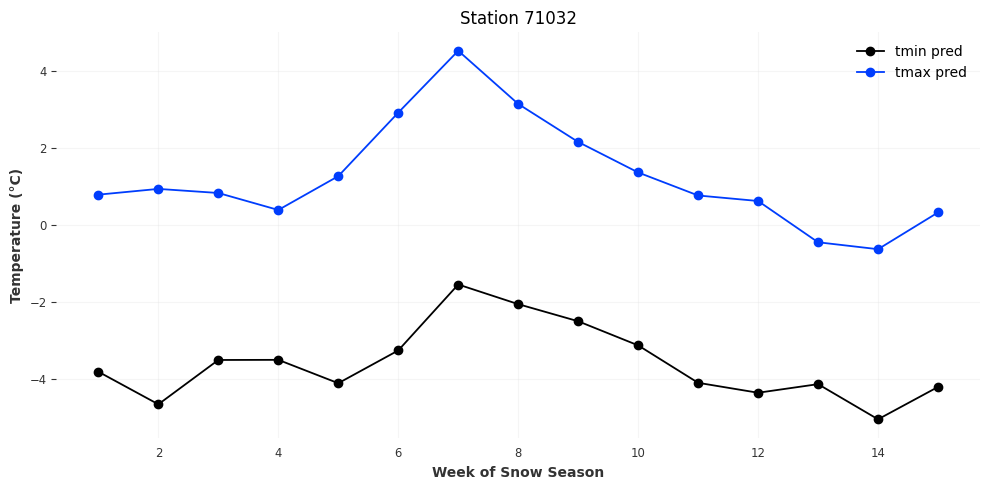

,station,year,week,pred_tmin,pred_tmax
0,71032,2026,1,-3.810,0.787
1,71032,2026,2,-4.655,0.936
2,71032,2026,3,-3.504,0.830
3,71032,2026,4,-3.501,0.389
4,71032,2026,5,-4.107,1.267
5,71032,2026,6,-3.257,2.916
6,71032,2026,7,-1.545,4.522
7,71032,2026,8,-2.055,3.141
8,71032,2026,9,-2.499,2.155
9,71032,2026,10,-3.125,1.363


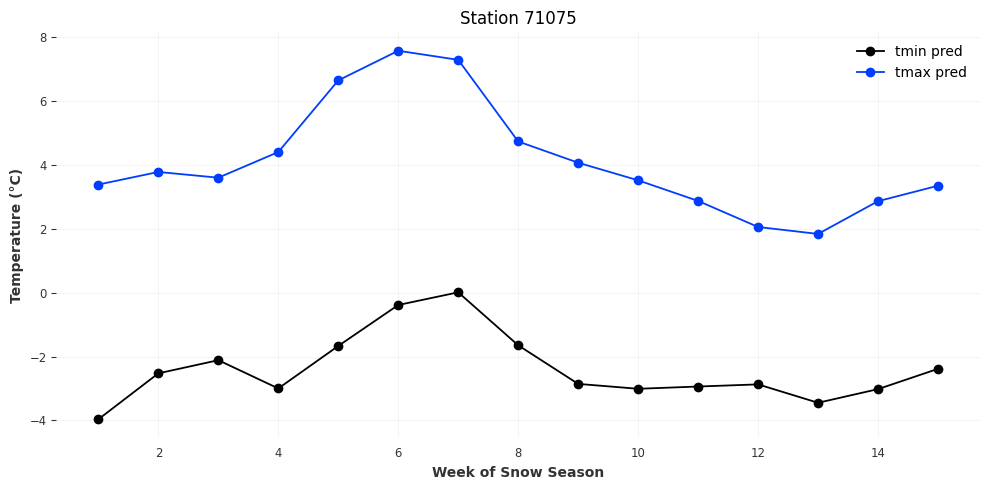

,station,year,week,pred_tmin,pred_tmax
0,71075,2026,1,-3.964,3.382
1,71075,2026,2,-2.526,3.776
2,71075,2026,3,-2.114,3.597
3,71075,2026,4,-2.999,4.399
4,71075,2026,5,-1.669,6.642
5,71075,2026,6,-0.387,7.569
6,71075,2026,7,0.010,7.285
7,71075,2026,8,-1.649,4.729
8,71075,2026,9,-2.856,4.065
9,71075,2026,10,-3.009,3.514


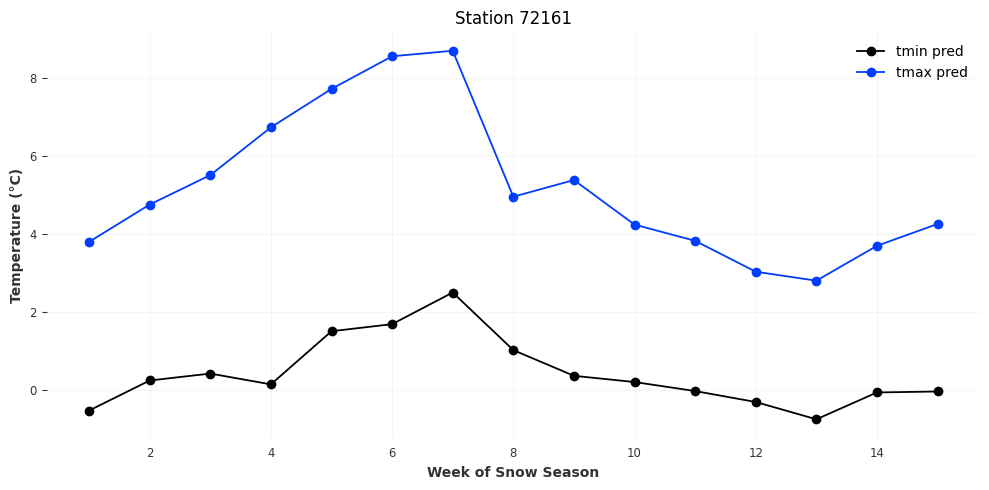

,station,year,week,pred_tmin,pred_tmax
0,72161,2026,1,-0.530,3.796
1,72161,2026,2,0.241,4.753
2,72161,2026,3,0.418,5.508
3,72161,2026,4,0.142,6.733
4,72161,2026,5,1.504,7.718
5,72161,2026,6,1.686,8.556
6,72161,2026,7,2.498,8.697
7,72161,2026,8,1.020,4.954
8,72161,2026,9,0.361,5.382
9,72161,2026,10,0.201,4.238


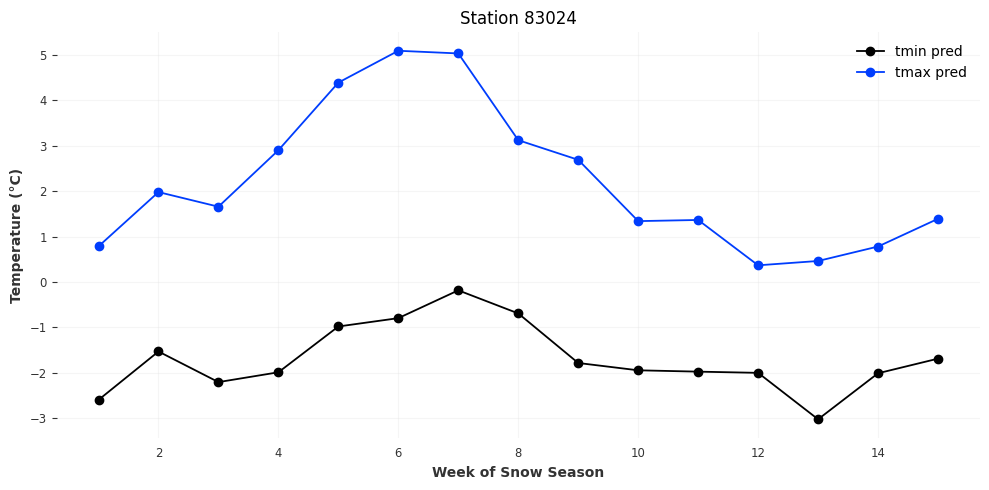

,station,year,week,pred_tmin,pred_tmax
0,83024,2026,1,-2.599,0.784
1,83024,2026,2,-1.533,1.980
2,83024,2026,3,-2.207,1.658
3,83024,2026,4,-1.991,2.902
4,83024,2026,5,-0.982,4.392
5,83024,2026,6,-0.798,5.094
6,83024,2026,7,-0.185,5.035
7,83024,2026,8,-0.694,3.123
8,83024,2026,9,-1.786,2.691
9,83024,2026,10,-1.947,1.340


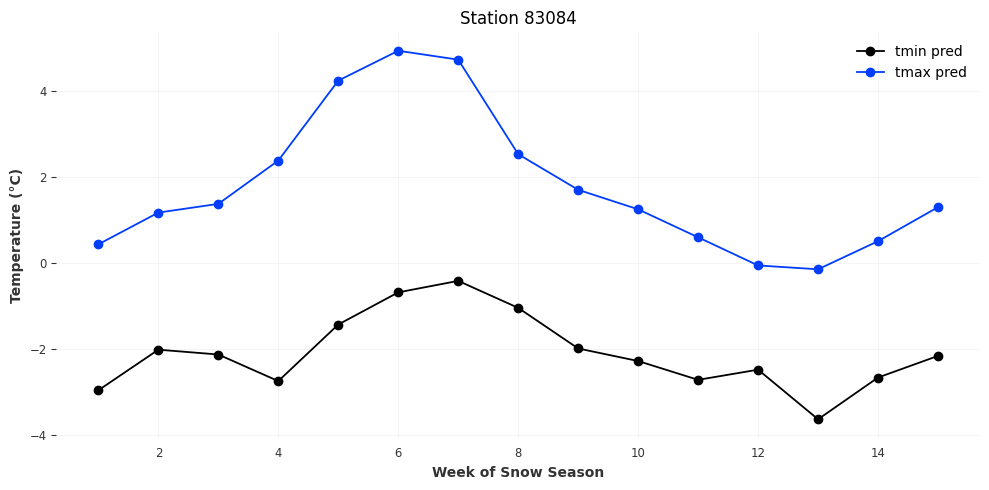

,station,year,week,pred_tmin,pred_tmax
0,83084,2026,1,-2.962,0.431
1,83084,2026,2,-2.019,1.169
2,83084,2026,3,-2.131,1.371
3,83084,2026,4,-2.749,2.378
4,83084,2026,5,-1.434,4.236
5,83084,2026,6,-0.686,4.930
6,83084,2026,7,-0.419,4.724
7,83084,2026,8,-1.046,2.526
8,83084,2026,9,-1.991,1.698
9,83084,2026,10,-2.283,1.244


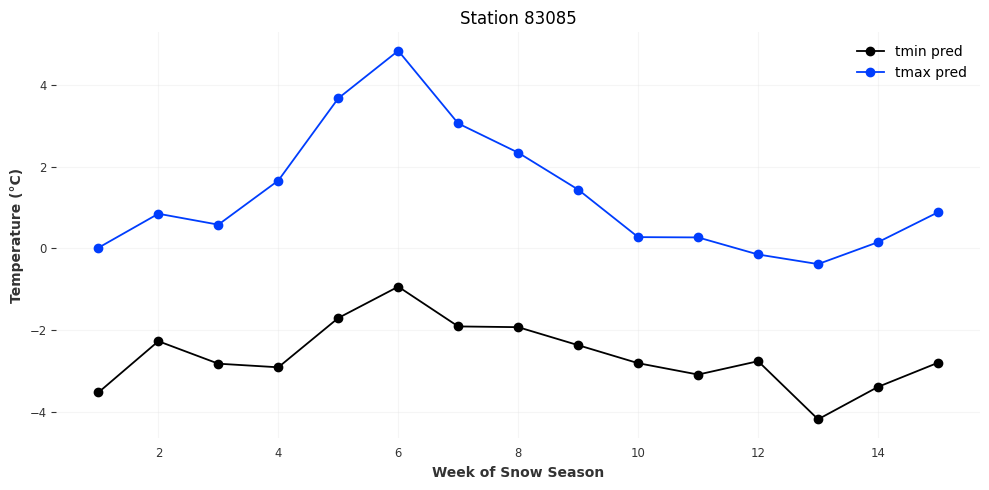

,station,year,week,pred_tmin,pred_tmax
0,83085,2026,1,-3.530,0.013
1,83085,2026,2,-2.274,0.846
2,83085,2026,3,-2.825,0.579
3,83085,2026,4,-2.913,1.659
4,83085,2026,5,-1.706,3.673
5,83085,2026,6,-0.940,4.837
6,83085,2026,7,-1.913,3.056
7,83085,2026,8,-1.931,2.341
8,83085,2026,9,-2.372,1.437
9,83085,2026,10,-2.813,0.274


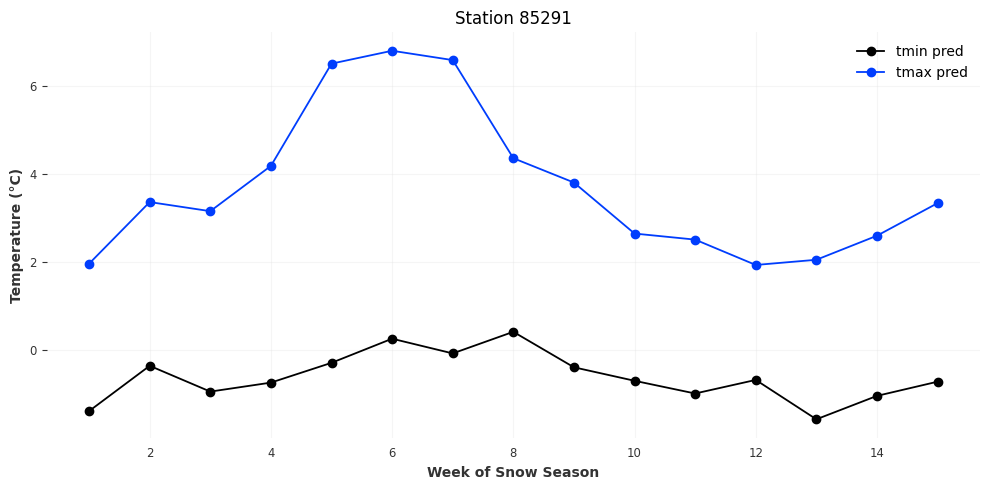

,station,year,week,pred_tmin,pred_tmax
0,85291,2026,1,-1.390,1.958
1,85291,2026,2,-0.361,3.359
2,85291,2026,3,-0.948,3.151
3,85291,2026,4,-0.743,4.180
4,85291,2026,5,-0.294,6.504
5,85291,2026,6,0.254,6.796
6,85291,2026,7,-0.080,6.584
7,85291,2026,8,0.411,4.355
8,85291,2026,9,-0.395,3.802
9,85291,2026,10,-0.702,2.643


In [25]:
# Load data
df = load_and_prepare(DATA_PATH)

# Backtest & leaderboard
print("Backtesting temperature models per station...")
metrics_all, all_preds_min, all_actuals_min, all_preds_max, all_actuals_max = run_all(df)

if metrics_all.empty:
    raise RuntimeError("No metrics produced — check input data.")

# Leaderboard (printed + displayed)
leaderboard = leaderboard_from_metrics(metrics_all)
print("\n=== Leaderboard (Overall RMSE across both targets; lower is better) ===")
print(leaderboard.to_string(index=False))
display(leaderboard.style.format({"overall_rmse": "{:.3f}", "mean_rmse": "{:.3f}", "median_rmse": "{:.3f}", "sd_rmse": "{:.3f}"}))

# 2024: predicted vs actual plots for each model (tmin & tmax on same graph)
station = PLOT_STATION or pick_station_for_plot(df)
if station is not None:
    plot_and_table_2024_per_model_temps(
        df,
        station,
        preds_min=all_preds_min.get(station, {}),
        actuals_min=all_actuals_min.get(station, {}),
        preds_max=all_preds_max.get(station, {}),
        actuals_max=all_actuals_max.get(station, {}),
        model_order=MODEL_NAMES,
    )
else:
    print("No suitable station found with both 2024 data and prior training years.")

# 2026: choose model (explicit or best from leaderboard), then plot+table for each station
chosen_model = PREDICTION_MODEL or (leaderboard.iloc[0]["model"] if not leaderboard.empty else "ExponentialSmoothing")
print(f"\nForecasting {FORECAST_YEAR} weekly temperatures using model: {chosen_model}")

forecast_long = forecast_2026_all_stations_temps(
    df,
    model_name=chosen_model,
    year=FORECAST_YEAR,
)

# Optional overview (stations × weeks × both targets) as a tidy table
overview = forecast_long.pivot_table(index="station", columns="week", values=["pred_tmin", "pred_tmax"])
display(Markdown(f"## Overview table — {FORECAST_YEAR} predictions (stations × weeks × [tmin,tmax])"))
display(np.round(overview, 3))

# Per-station plots + tables
plot_and_table_2026_per_station_temps(
    long_df=forecast_long,
    model_name=chosen_model,
    year=FORECAST_YEAR,
    max_stations=PLOT_MAX_STATIONS,  # set to an int to limit number of outputs
)
